In [1]:
import os
import glob

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter

import torchvision
from torchvision import transforms

import kornia as K

import matplotlib.pyplot as plt
from PIL import Image

from AugmentationsDataset import *

from utils import plot_tensor, show_sample, learning_grid

In [2]:
### --- Config --- ###
# dataset
target_rotation_deg = 90.

# training
init_rotation_deg = 50.
batch_size = 64
epochs = 1
lr=0.1
# momentum=0.9

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# paths:
run_name = f'init-{init_rotation_deg}_target-{target_rotation_deg}'

figures_dir = f'figures'
run_figures_dir = f'{figures_dir}/{run_name}'

gifs_dir = f'gifs'
run_gif_name = f'{gifs_dir}/{run_name}.gif'

os.makedirs(run_figures_dir, exist_ok=True)
os.makedirs(gifs_dir, exist_ok=True)

In [3]:
source_transform = transforms.Compose([
    transforms.ToTensor()
])

target_augmentations = transforms.Compose([
    K.augmentation.RandomRotation(degrees=[target_rotation_deg,target_rotation_deg], p=1), # nn.Module
])

target_transform = transforms.Compose([
    transforms.ToTensor(),
    target_augmentations
])

In [4]:
glob_path = '../data/tiny-imagenet-200/train/*/images/*'
dataset = AugmentationsDataset(glob_path,
                               source_transform, target_transform,)

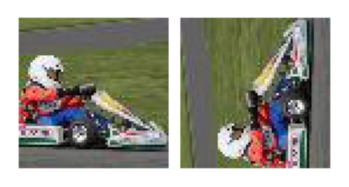

In [5]:
show_sample(dataset[0])

In [6]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

In [7]:
class AugmentationNetwork(nn.Module):
    def __init__(self, init_rot_degree):
        super().__init__()
        self.trans_param = Parameter(torch.Tensor([init_rot_degree]),
                                     requires_grad=True)

    def forward(self, x):
        rand_rotation = K.augmentation.RandomRotation(
                        torch.cat([self.trans_param, self.trans_param]), p=1) # torch cat prevernts parameter from casting to float.
        out = rand_rotation(x)
        return out

In [8]:
model = AugmentationNetwork(init_rot_degree=init_rotation_deg)
model.to(device)

AugmentationNetwork()

In [9]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

trans_param tensor([50.], device='cuda:0')


In [10]:
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [11]:
losses = []
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(dataloader):
        source_images, target_images = data
        source_images, target_images = source_images.to(device), target_images.to(device)
        
        optimizer.zero_grad()

        output_images = model(source_images)
        loss = criterion(output_images, target_images)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        running_loss += loss.item()
        print_every = 10
        if i % print_every == print_every - 1:
            print(f'[Epoch: {epoch+1} | Batch: {i+1} | MSE Loss: {running_loss/print_every:.3f} | {model.trans_param.item()}]')
            running_loss = 0.0

            with torch.no_grad():
                img_dict = {
                    "source": dataset[0][0],
                    "model's output": model(dataset[0][0]).squeeze(),
                    "target": dataset[0][1]
                }
                learning_grid(img_dict, save=f'{run_figures_dir}/epoch-{epoch+1:02}_batch-{i+1:05}.png')
                
        if i == 1000:
            break

print('Finished Training.')

[Epoch: 1 | Batch: 10 | MSE Loss: 0.109 | 50.988887786865234]
[Epoch: 1 | Batch: 20 | MSE Loss: 0.109 | 51.969688415527344]
[Epoch: 1 | Batch: 30 | MSE Loss: 0.106 | 52.960662841796875]
[Epoch: 1 | Batch: 40 | MSE Loss: 0.114 | 53.86271286010742]
[Epoch: 1 | Batch: 50 | MSE Loss: 0.106 | 54.857147216796875]
[Epoch: 1 | Batch: 60 | MSE Loss: 0.107 | 55.8856201171875]
[Epoch: 1 | Batch: 70 | MSE Loss: 0.104 | 56.964576721191406]
[Epoch: 1 | Batch: 80 | MSE Loss: 0.106 | 58.06534957885742]
[Epoch: 1 | Batch: 90 | MSE Loss: 0.099 | 59.17012405395508]
[Epoch: 1 | Batch: 100 | MSE Loss: 0.102 | 60.308841705322266]
[Epoch: 1 | Batch: 110 | MSE Loss: 0.102 | 61.52296829223633]
[Epoch: 1 | Batch: 120 | MSE Loss: 0.098 | 62.747596740722656]
[Epoch: 1 | Batch: 130 | MSE Loss: 0.096 | 63.991844177246094]
[Epoch: 1 | Batch: 140 | MSE Loss: 0.091 | 65.263427734375]
[Epoch: 1 | Batch: 150 | MSE Loss: 0.091 | 66.55022430419922]
[Epoch: 1 | Batch: 160 | MSE Loss: 0.092 | 67.89835357666016]
[Epoch: 1 | 

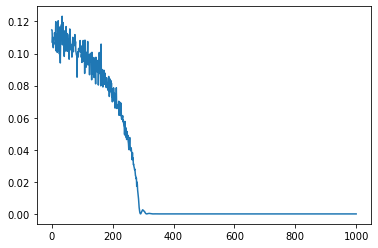

In [12]:
plt.plot(losses)

In [13]:
# filepaths
fp_in = f"{run_figures_dir}/epoch-*"
fp_out = run_gif_name

imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=75, loop=0)

In [14]:
fp_out

'gifs/init-50.0_target-90.0.gif'